In [28]:
import glob
import os
import parselmouth
from collections import defaultdict
import matplotlib.pyplot as plt

In [4]:
files = glob.glob("m:/corpres/careva/cta/**/*.seg_Y1", recursive=True)

In [6]:
from itertools import product
letters = "GBRY"
nums = "1234"
levels = [ch + num for num, ch in product(nums, letters)]
level_codes = [2 ** i for i in range(len(levels))]
code_to_level = {i: j for i, j in zip(level_codes, levels)}
level_to_code = {j: i for i, j in zip(level_codes, levels)}

In [7]:
def read_seg(filename: str, encoding: str = "utf-8-sig") -> tuple[dict, list[dict]]:
    with open(filename, encoding=encoding) as f:
        lines = [line.strip() for line in f.readlines()]

    # найдём границы секций в списке строк:
    header_start = lines.index("[PARAMETERS]") + 1
    data_start = lines.index("[LABELS]") + 1

    # прочитаем параметры
    params = {}
    for line in lines[header_start:data_start - 1]:
        key, value = line.split("=")
        params[key] = int(value)

    # прочитаем метки
    labels = []
    for line in lines[data_start:]:
        # если в строке нет запятых, значит, это не метка и метки закончились
        if line.count(",") < 2:
            break
        pos, level, name = line.split(",", maxsplit=2)
        label = {
            "position": int(pos) // params["BYTE_PER_SAMPLE"] // params["N_CHANNEL"],
            "level": code_to_level[int(level)],
            "name": name
        }
        labels.append(label)
    return params, labels

In [47]:
def split_into_ips(file):
    try:
        params, word_labels = read_seg(file, encoding="cp1251")
    except Exception:
        params, word_labels = read_seg(file, encoding="utf-8-sig")
    _, sound_labels = read_seg(file.replace(".seg_Y1", ".seg_B1"))
    _, ip_labels = read_seg(file.replace(".seg_Y1", ".seg_R2"))

    ip_list = []
    wi = 0
    si = 0
    for r1, r2 in zip(ip_labels, ip_labels[1:]):
        if r1["name"].startswith("p") or not r1["name"]:
            continue
        ip = {"words": [], "model": r1["name"], "start": r1["position"], "end": r2["position"], "nucleus": None}
        ip_list.append(ip)
        for w1, w2 in zip(word_labels[wi:], word_labels[wi+1:]):
            if w1["position"] >= r2["position"]:
                break
            wi += 1
            if not w1["name"] or w1["position"] < r1["position"]:
                continue
            word = {"sounds": [], "word": w1["name"], "start": w1["position"], "end": w2["position"], "is_prominent": False, "is_nucleus": False, "is_stressed": False, "stressed_vowel": None}
            ip["words"].append(word)
            if word["word"].startswith("[+]"):
                word["is_prominent"] = True
            elif word["word"].startswith("[-]"):
                word["is_nucleus"] = True
                ip["nucleus"] = len(ip["words"]) - 1
            sound_counter = 0
            for s1, s2 in zip(sound_labels[si:], sound_labels[si+1:]):
                if s1["position"] >= w2["position"]:
                    break
                si += 1
                if not s1["name"] or s1["position"] < w1["position"]:
                    continue
                sound = {"sound": s1["name"], "start": s1["position"], "end": s2["position"]}
                if sound["sound"].endswith("0"):
                    word["is_stressed"] = True
                    word["stressed_vowel"] = sound_counter
                word["sounds"].append(sound)
                sound_counter += 1
        
        if ip["nucleus"] is None:
            for i, word in enumerate(ip["words"][::-1]):
                if word["is_stressed"]:
                    word["is_nucleus"] = True
                    ip["nucleus"] = len(ip["words"]) - 1 - i
                    break
    return ip_list
    

In [22]:
split_into_ips(files[2])

[{'words': [{'sounds': [{'sound': 'v', 'start': 0, 'end': 2762}],
    'word': 'в',
    'start': 0,
    'end': 2762,
    'is_prominent': False,
    'is_nucleus': False,
    'is_stressed': False,
    'stressed_vowel': None},
   {'sounds': [{'sound': 'y1', 'start': 2762, 'end': 4569},
     {'sound': 'j', 'start': 4569, 'end': 7136},
     {'sound': 'u0', 'start': 7136, 'end': 9284},
     {'sound': "l'", 'start': 9284, 'end': 10888},
     {'sound': 'i4', 'start': 10888, 'end': 12422}],
    'word': 'июле',
    'start': 2762,
    'end': 12422,
    'is_prominent': False,
    'is_nucleus': True,
    'is_stressed': True,
    'stressed_vowel': 2}],
  'model': '12',
  'start': 0,
  'end': 12422,
  'nucleus': 1},
 {'words': [{'sounds': [{'sound': 'm', 'start': 12422, 'end': 15353},
     {'sound': 'a0', 'start': 15353, 'end': 17940},
     {'sound': "d'", 'start': 17940, 'end': 19588}],
    'word': 'мать',
    'start': 12422,
    'end': 19588,
    'is_prominent': False,
    'is_nucleus': False,
    '

In [48]:
models = defaultdict(list)
fs = 22050

for file in files[:15]:
    ip_list = split_into_ips(file)
    sound = parselmouth.praat.call("Read Sound from raw 16-bit Little Endian file", file.replace(".seg_Y1", ".sbl"))
    sound.override_sampling_frequency(fs)
    for ip in ip_list:
        nucleus_word = ip["words"][ip["nucleus"]]
        nucleus_vowel = nucleus_word["sounds"][nucleus_word["stressed_vowel"]]
        vowel_part = sound.extract_part(nucleus_vowel["start"] / fs, nucleus_vowel["end"] / fs)
        models[ip["model"]].append(vowel_part)

In [49]:
len(models)

8

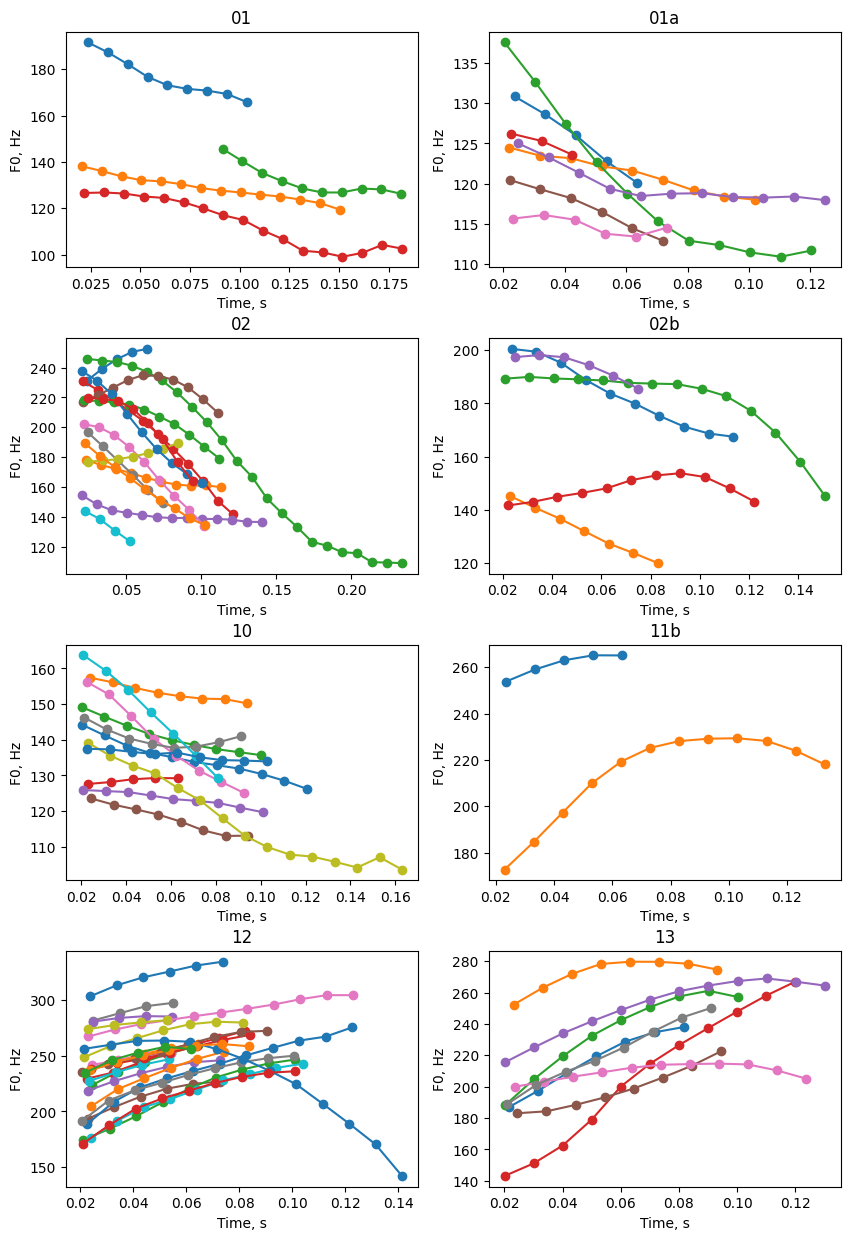

In [53]:
step, min_f0, max_f0 = 0.01, 75, 350  # s, Hz, Hz
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
for ax, model in zip(axes.flatten(), sorted(models)):
    for sound in models[model]:
        manip = parselmouth.praat.call(sound, "To Manipulation", step, min_f0, max_f0)
        pitch_tier = parselmouth.praat.call(manip, "Extract pitch tier")
        num_points = parselmouth.praat.call(pitch_tier, "Get number of points")
        time_values = []
        f0_values = []
        for i in range(1, num_points + 1):
            time_values.append(parselmouth.praat.call(pitch_tier, "Get time from index", i))
            f0_values.append(parselmouth.praat.call(pitch_tier, "Get value at index", i))
        ax.plot(time_values, f0_values, linestyle="-", marker="o")
        ax.set_xlabel("Time, s")
        ax.set_ylabel("F0, Hz")
        ax.set_title(model)

plt.subplots_adjust(hspace=0.3)
plt.show()